# 2. One-vs-One Kernel Perceptron

## Libraries

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import time
from tqdm import tqdm
from tabulate import tabulate

from sklearn.metrics.pairwise import polynomial_kernel
from sklearn.metrics.pairwise import euclidean_distances

## Import Data

In [2]:
#import the dataset
df = pd.read_csv('zipcombo.csv')
df.head()

,label,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
0,6.0,-1.0,-1.0,-1.0,-1.000,-1.000,-1.000,-1.000,-0.631,0.862,...,0.304,0.823,1.000,0.482,-0.474,-0.991,-1.000,-1.000,-1.000,-1.0
1,5.0,-1.0,-1.0,-1.0,-0.813,-0.671,-0.809,-0.887,-0.671,-0.853,...,-0.671,-0.671,-0.033,0.761,0.762,0.126,-0.095,-0.671,-0.828,-1.0
2,4.0,-1.0,-1.0,-1.0,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,...,-1.000,-1.000,-1.000,-0.109,1.000,-0.179,-1.000,-1.000,-1.000,-1.0
3,7.0,-1.0,-1.0,-1.0,-1.000,-1.000,-0.273,0.684,0.960,0.450,...,-0.318,1.000,0.536,-0.987,-1.000,-1.000,-1.000,-1.000,-1.000,-1.0
4,3.0,-1.0,-1.0,-1.0,-1.000,-1.000,-0.928,-0.204,0.751,0.466,...,0.466,0.639,1.000,1.000,0.791,0.439,-0.199,-0.883,-1.000,-1.0


In [10]:
#split the data into features X and target y
X = df[df.columns[1:]].values.copy()
y = df['label'].values.copy()

## Helper Functions

In [44]:
#a permutation function to obtain the combinations of classes corresponding to each binary classifier
def permutation(classes):
    def backtrack(nums, stack, start):
        if len(stack) == 2:
            res.append(stack)
            return
        for i in range(start, len(nums)):
            stack = stack + [nums[i]]
            backtrack(nums, stack, i+1)
            stack = stack[:-1]
    res = []
    backtrack(classes, [], 0)
    return res

## Kernel Functions

In [4]:
#function to perform mapping with the polynomial kernel
def polynomial(X_i, X_j, d):
    '''
    d: dimension fo the polynomial kernel
    '''
    K = ( X_i.dot(X_j.T) ) ** d
    return K

#a fast implementaion of the polynomial kernel
def fast_polynomial(X_i, X_j, d):
    '''
    d: dimension fo the polynomial kernel
    '''
    K = polynomial_kernel(X_i, Y=X_j, degree=d)
    return K 

#function to perform mapping with the gaussian kernel
def gaussian(X_i, X_j, c):
    '''
    c: width of the gaussian kernel
    '''
    m, n = len(X_i), len(X_j)
    K = np.zeros((m,n))            #initialize the mapped feature matrix
    for i in range(m):
        for j in range(n):
            K[i][j] = np.exp( -c * np.linalg.norm(X_i[i]-X_j[j]) ** 2 )
    return K

#a faster implementation of the gaussian kernel
def fast_gaussian(X_i, X_j, c):
    '''
    c: width of the gaussian kernel
    '''
    K = euclidean_distances(X_i, X_j)
    K = np.exp( -c * K ** 2 )
    return K

## Train-Test Split Functions

In [6]:
def shuffle_data(X, y, seed=None):
    if seed:                         #set a random seed for reproducable results
        np.random.seed(seed)
    idx = np.arange(len(X))          
    np.random.shuffle(idx)           #shuffle the index
    return X[idx], y[idx]

#function to perform train-test split
def train_test_split(X, y, train_split, shuffle, seed=None):
    '''
    train_split: percentage of data for training
    '''
    if shuffle:                                     #shuffle the data if needed
        X, y = shuffle_data(X, y, seed)
    n_train = int(train_split*len(X))               #find the split location
    X_train, X_test = X[:n_train], X[n_train:]      
    y_train, y_test = y[:n_train], y[n_train:]
    return X_train, X_test, y_train, y_test

#function to split data for k-fold cross-validation
def KFold(X, y, k):
    m = len(X)
    n_split = int(m/k)         
    X_train_fold, X_valid_fold, y_train_fold, y_valid_fold = [], [], [], []
    for fold in range(1, k+1):
        X_valid = X[(fold-1)*n_split:fold*n_split]
        y_valid = y[(fold-1)*n_split:fold*n_split]
        X_train = np.append(X[0:(fold-1)*n_split], X[fold*n_split:], axis=0)
        y_train = np.append(y[0:(fold-1)*n_split], y[fold*n_split:], axis=0)
        X_train_fold.append(X_train)
        X_valid_fold.append(X_valid)
        y_train_fold.append(y_train)
        y_valid_fold.append(y_valid)
    return X_train_fold, X_valid_fold, y_train_fold, y_valid_fold

## One-vs-One Kernel Perceptron

<div>
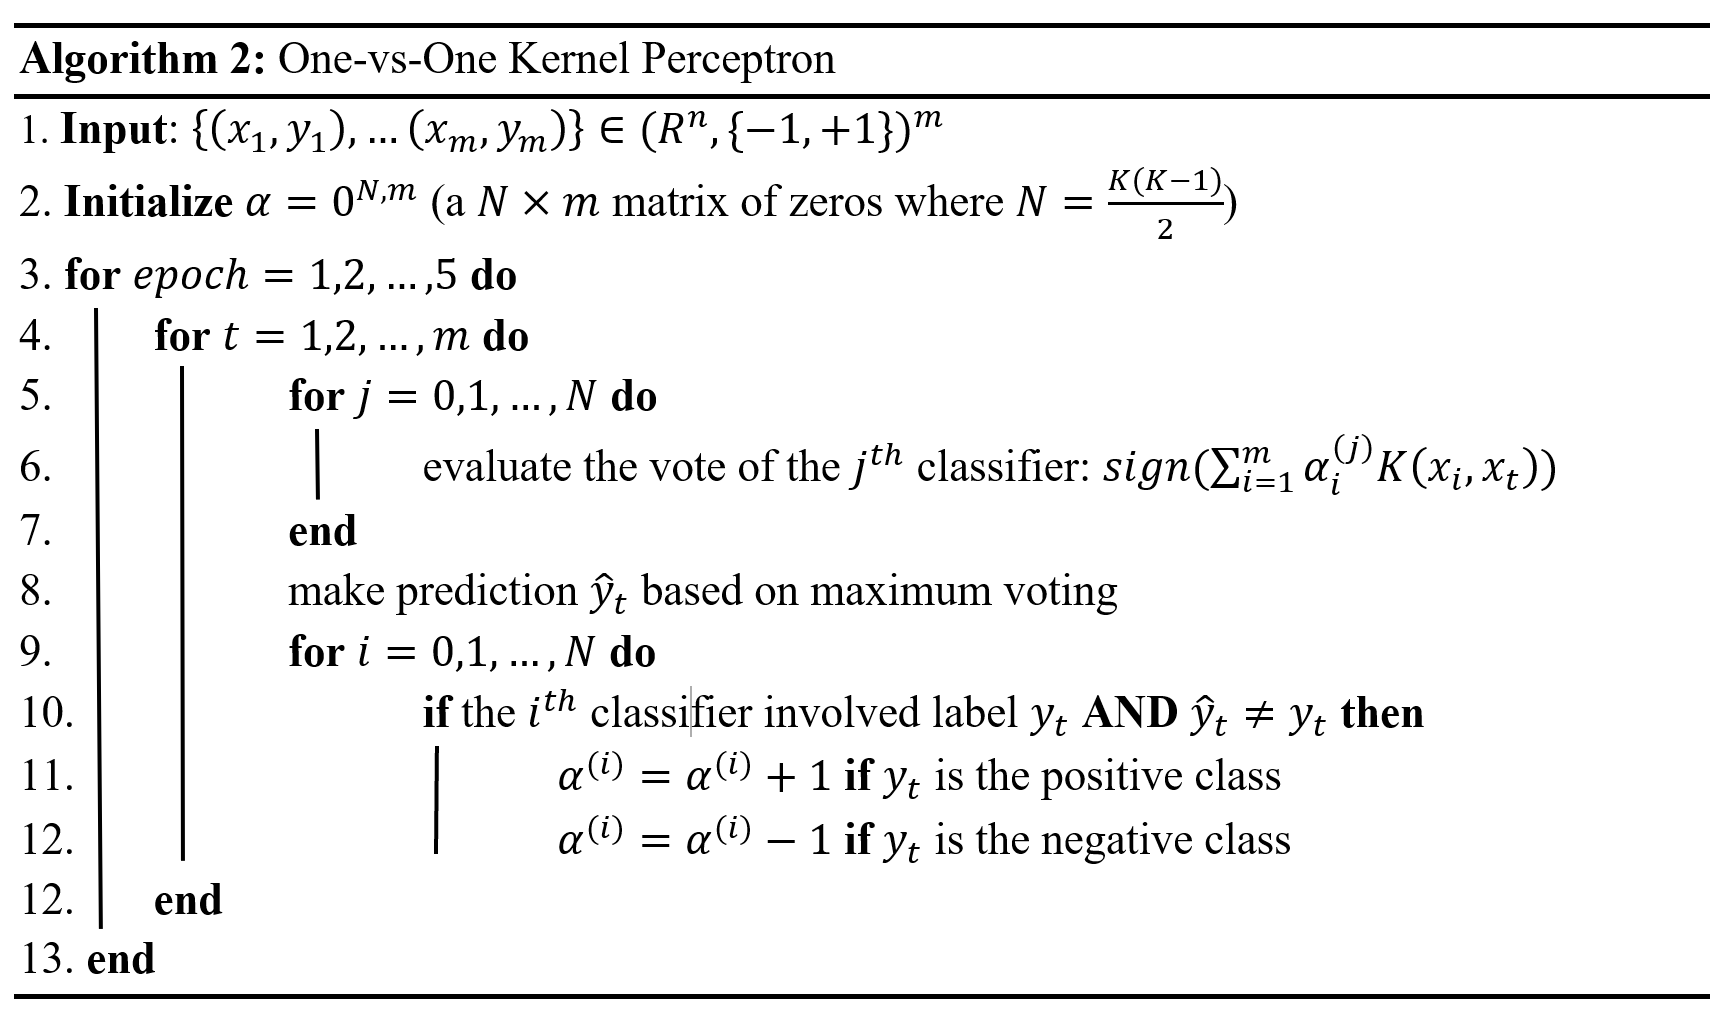
</div>

In [74]:
class MultiKernelPerceptron(object):
    
    def __init__(self, X_train, y_train, X_test, y_test, kernel, kernel_param, epochs):
        #initialize the datasets
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        #initialize the sizes
        self.epochs = epochs
        self.batch_size = len(self.y_train)  
        self.test_size = len(self.y_test)
        self.classes = np.unique(np.append(self.y_train, self.y_test))
        self.n_c = len(self.classes)
        self.N = int(self.n_c*(self.n_c-1)/2)
        #initialize the combination of classes for each classifier
        self.classifiers = sorted(permutation(list(self.classes)))
        #initialize the kernel method
        self.kernel = kernel
        self.kernel_param = kernel_param
        #initialize the mapped data with kernelization
        if kernel == 'p':
            self.K = fast_polynomial(self.X_train, self.X_train, self.kernel_param)
            self.K_test = fast_polynomial(self.X_test, self.X_train, self.kernel_param)
        if kernel =='g':
            self.K = fast_gaussian(self.X_train, self.X_train, self.kernel_param)
            self.K_test = fast_gaussian(self.X_test, self.X_train, self.kernel_param)   
        #initialize the alpha matrix: N × m
        self.alpha = np.zeros(shape=(self.N, self.batch_size))
        

    def predict(self, i, data):
        if data == 'train':
            K = self.K[i]
        elif data == 'test':
            K = self.K_test[i]
        votes = np.sign(np.dot(self.alpha, K))                 #compute the votes
        individual_votes = [0] * self.n_c
        for i in range(self.N):                                #for each classifier
            combo = self.classifiers[i]                        #classes involved in the ith classifier
            vote = combo[0] if votes[i] > 0 else combo[1]    #the class that the ith classifier voted for
            individual_votes[int(vote)] += 1                        #increase the vote for this class by 1
        y_pred = np.argmax(individual_votes)                   #make the final prediction based on maximum voting
        return y_pred
        

    def train(self):
        for _ in range(self.epochs):                    #train the algorithm over 10 epoches
            errors = 0                                  #reset the count of mistakes to 0 at the beginning of each epoch
            for i in range(self.batch_size):            #sequentially train the algorithm over each sample
                y_pred = self.predict(i, 'train')       #make prediction for the ith sample
                label = int(self.y_train[i])            #obtain the true label of the ith sample
                if int(y_pred) != label:                #if the final prediction does not match the true label
                    errors += 1
                    for j in range(self.N):             #for each classifier
                        combo = self.classifiers[j]     #classes involved in the jth classifier
                        if int(label) in combo:         #if the classifier involves the label for the ith sample
                            self.alpha[j, i] += 1 if combo[0]==label else -1
            error_rate = (errors/self.batch_size) * 100            #compute the error rate for this epoch
        return error_rate                                          #return the training error rate on the last epoch
    
    
    def test(self):
        errors = 0
        for i in range(self.test_size):
            y_pred = self.predict(i, 'test')      
            label = int(self.y_test[i])
            if int(y_pred) != label:
                errors += 1
        error_rate = (errors/self.test_size) * 100 
        return error_rate 

## Basic Result

In [75]:
#initialization
np.random.seed(0)
train_split = 0.8
d_list = np.arange(1,8)
train_error, train_std, test_error, test_std = [], [], [], []

for d in d_list:               #for different dimensions of the polynomial kernel
    single_run_train_errors, single_run_test_errors = [], []
    for run in tqdm(range(20)):      #perform 20 runs
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_split, shuffle=True)     #randomly split the data
        clf = MultiKernelPerceptron(X_train, y_train, X_test, y_test, kernel='p', kernel_param=d, epochs=5)
        train_e = clf.train()                            #compute the training error on the 80% data
        single_run_train_errors.append(train_e)
        test_e = clf.test()                              #compute the test error on the 20% data
        single_run_test_errors.append(test_e) 
    train_error.append(np.mean(single_run_train_errors))
    train_std.append(np.std(single_run_train_errors))
    test_error.append(np.mean(single_run_test_errors))
    test_std.append(np.std(single_run_test_errors))
    print('Polynomial order: ', d, ', mean train error: ', train_error[-1], ', mean test error: ', test_error[-1])

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Polynomial order:  1 , mean train error:  10.400645334767411 , mean test error:  11.180107526881722


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Polynomial order:  2 , mean train error:  8.275073944608767 , mean test error:  9.344086021505378


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Polynomial order:  3 , mean train error:  6.4842699650443665 , mean test error:  7.935483870967742


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Polynomial order:  4 , mean train error:  5.1573003495563325 , mean test error:  7.155913978494624


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Polynomial order:  5 , mean train error:  3.8128529174509276 , mean test error:  6.451612903225806


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Polynomial order:  6 , mean train error:  2.7493949986555526 , mean test error:  6.005376344086021


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [05:08<00:00, 15.42s/it]

Polynomial order:  7 , mean train error:  1.9292820650712552 , mean test error:  5.629032258064516


In [76]:
#tabulate the results
data = []
for i in range(len(d_list)):
    train_result = f"{'{:.4f}'.format(train_error[i])}±{'{:.4f}'.format(train_std[i])}"
    test_result = f"{'{:.4f}'.format(test_error[i])}±{'{:.4f}'.format(test_std[i])}"
    result = [int(d_list[i]), train_result, test_result]
    data.append(result)
print(tabulate(data, 
               headers = ["d", "Mean Train Error Rates (%)", "Mean Test Error Rates (%)"], 
               tablefmt = "simple_outline",
               stralign = "center"))

┌─────┬──────────────────────────────┬─────────────────────────────┐
│   d │  Mean Train Error Rates (%)  │  Mean Test Error Rates (%)  │
├─────┼──────────────────────────────┼─────────────────────────────┤
│   1 │        10.4006±0.2609        │       11.1801±1.3514        │
│   2 │        8.2751±0.2533         │        9.3441±0.7706        │
│   3 │        6.4843±0.2309         │        7.9355±0.7961        │
│   4 │        5.1573±0.1596         │        7.1559±0.6411        │
│   5 │        3.8129±0.2346         │        6.4516±0.4705        │
│   6 │        2.7494±0.2016         │        6.0054±0.7436        │
│   7 │        1.9293±0.2232         │        5.6290±0.4916        │
└─────┴──────────────────────────────┴─────────────────────────────┘


## Cross-Validation

In [77]:
#initialization 
np.random.seed(1)
train_split = 0.8
d_stars, test_errors = [], []

for run in tqdm(range(20)):          #perform 20 runs
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_split, shuffle=True)     #randomly split the data
    d_star, best_error = 0, float('inf')            #initialize the best d and best error
    for d in d_list:           #try different dimensions of the polynomial kernel
        valid_errors = []      #initialize a list to store validation errors
        X_train_frold, X_valid_fold, y_train_fold, y_valid_fold = KFold(X_train, y_train, 5)    #split the training set into 5 folds
        for Xtrain, Xvalid, ytrain, yvalid in zip(X_train_frold, X_valid_fold, y_train_fold, y_valid_fold):
            clf = MultiKernelPerceptron(Xtrain, ytrain, Xvalid, yvalid, kernel='p', kernel_param=d, epochs=5)
            train_error = clf.train()               #train the classifier
            valid_errors.append(clf.test())         #evalaute the classifier on the validation set
        if np.mean(valid_errors) < best_error:      #if the current d value gives a lower error rate
            best_error = np.mean(valid_errors)      #update the best error so far
            d_star = d                              #update the best d value so far
    #retrain the classifier on the entire training set with the best d value
    clf = MultiKernelPerceptron(X_train, y_train, X_test, y_test, kernel='p', kernel_param=d_star, epochs=5)   
    train_error = clf.train()
    test_error = clf.test()
    test_errors.append(test_error)
    d_stars.append(d_star)
    print('d*: ', d_star, ', test error rate: ', test_errors[-1])

  5%|████                                                                            | 1/20 [06:01<1:54:19, 361.04s/it]

d*:  7 , test error rate:  6.290322580645161


 10%|████████                                                                        | 2/20 [11:55<1:47:08, 357.15s/it]

d*:  7 , test error rate:  4.731182795698925


 15%|████████████                                                                    | 3/20 [17:46<1:40:20, 354.14s/it]

d*:  7 , test error rate:  6.129032258064516


 20%|████████████████                                                                | 4/20 [24:08<1:37:26, 365.41s/it]

d*:  7 , test error rate:  5.64516129032258


 25%|████████████████████                                                            | 5/20 [29:08<1:25:25, 341.69s/it]

d*:  7 , test error rate:  6.666666666666667


 30%|████████████████████████                                                        | 6/20 [33:38<1:14:03, 317.40s/it]

d*:  7 , test error rate:  6.075268817204301


 35%|████████████████████████████                                                    | 7/20 [38:33<1:07:11, 310.09s/it]

d*:  7 , test error rate:  4.56989247311828


 40%|████████████████████████████████                                                | 8/20 [43:16<1:00:15, 301.31s/it]

d*:  7 , test error rate:  6.075268817204301


 45%|████████████████████████████████████                                            | 9/20 [52:36<1:10:06, 382.43s/it]

d*:  7 , test error rate:  5.698924731182796


 50%|███████████████████████████████████████▌                                       | 10/20 [59:49<1:06:18, 397.89s/it]

d*:  7 , test error rate:  5.64516129032258


 55%|███████████████████████████████████████████▍                                   | 11/20 [1:03:24<51:17, 341.90s/it]

d*:  7 , test error rate:  6.451612903225806


 60%|███████████████████████████████████████████████▍                               | 12/20 [1:06:58<40:24, 303.04s/it]

d*:  6 , test error rate:  6.182795698924731


 65%|███████████████████████████████████████████████████▎                           | 13/20 [1:10:36<32:20, 277.23s/it]

d*:  7 , test error rate:  5.752688172043011


 70%|███████████████████████████████████████████████████████▎                       | 14/20 [1:14:13<25:53, 258.93s/it]

d*:  6 , test error rate:  6.612903225806452


 75%|███████████████████████████████████████████████████████████▎                   | 15/20 [1:17:41<20:19, 243.85s/it]

d*:  6 , test error rate:  6.182795698924731


 80%|███████████████████████████████████████████████████████████████▏               | 16/20 [1:21:24<15:50, 237.52s/it]

d*:  7 , test error rate:  6.236559139784946


 85%|███████████████████████████████████████████████████████████████████▏           | 17/20 [1:25:07<11:39, 233.06s/it]

d*:  7 , test error rate:  5.860215053763441


 90%|███████████████████████████████████████████████████████████████████████        | 18/20 [1:28:39<07:33, 226.86s/it]

d*:  6 , test error rate:  5.43010752688172


 95%|███████████████████████████████████████████████████████████████████████████    | 19/20 [1:32:09<03:41, 221.69s/it]

d*:  7 , test error rate:  5.376344086021505


100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [1:35:40<00:00, 287.04s/it]

d*:  7 , test error rate:  6.451612903225806


In [78]:
#tabulate the results
data = []
for i in range(20):
    test_result = f"{'{:.4f}'.format(test_errors[i])}"
    result = [int(i+1), d_stars[i], test_result]
    data.append(result)
print(tabulate(data, 
               headers = ["run", "d*", "Mean Test Error Rates (%)"], 
               tablefmt = "simple_outline",
               numalign = "center"))

┌───────┬──────┬─────────────────────────────┐
│  run  │  d*  │  Mean Test Error Rates (%)  │
├───────┼──────┼─────────────────────────────┤
│   1   │  7   │           6.2903            │
│   2   │  7   │           4.7312            │
│   3   │  7   │            6.129            │
│   4   │  7   │           5.6452            │
│   5   │  7   │           6.6667            │
│   6   │  7   │           6.0753            │
│   7   │  7   │           4.5699            │
│   8   │  7   │           6.0753            │
│   9   │  7   │           5.6989            │
│  10   │  7   │           5.6452            │
│  11   │  7   │           6.4516            │
│  12   │  6   │           6.1828            │
│  13   │  7   │           5.7527            │
│  14   │  6   │           6.6129            │
│  15   │  6   │           6.1828            │
│  16   │  7   │           6.2366            │
│  17   │  7   │           5.8602            │
│  18   │  6   │           5.4301            │
│  19   │  7 

In [79]:
print('Mean d*: ', f"{'{:.1f}'.format(np.mean(d_stars))} ± {'{:.1f}'.format(np.std(d_stars))}")
print('Mean Test Error (%): ', f"{'{:.2f}'.format(np.mean(test_errors))} ± {'{:.2f}'.format(np.std(test_errors))}")

Mean d*:  6.8 ± 0.4
Mean Test Error (%):  5.90 ± 0.55
